테스트할 이미지를 업로드해주세요.


Saving skincare-beauty-face-black-woman-studio-with-cropped-headshot-beauty-products-cosmetics-makeup-portrait-girl-model-facial-skincare-products-luxury-spa-body-care_590464-112642.JPG to skincare-beauty-face-black-woman-studio-with-cropped-headshot-beauty-products-cosmetics-makeup-portrait-girl-model-facial-skincare-products-luxury-spa-body-care_590464-112642 (1).JPG

1개의 얼굴을 찾았습니다.


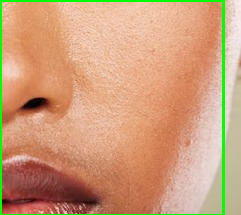

얼굴 #1


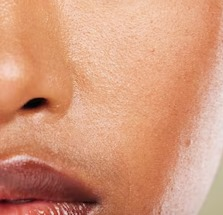

In [31]:
import cv2
import numpy as np
import os
from google.colab import files
from google.colab.patches import cv2_imshow

class FaceDetector:
    def __init__(self, model_filename='face_detection_yunet_2023mar.onnx'):
        if not os.path.exists(model_filename):
            !wget -q https://github.com/opencv/opencv_zoo/raw/main/models/face_detection_yunet/{model_filename}
        self.detector = cv2.FaceDetectorYN.create(model_filename, "", (0, 0))

    def _resize_image(self, img, target_size=None):
        if target_size is not None:
            original_h, original_w, _ = img.shape
            if original_h > original_w:
                new_h, new_w = target_size, int(original_w * target_size / original_h)
            else:
                new_h, new_w = int(original_h * target_size / original_w), target_size
            return cv2.resize(img, (new_w, new_h))
        return img

    def _detect_faces(self, img, score_threshold=0.9):
        h, w, _ = img.shape
        self.detector.setInputSize((w, h))
        self.detector.setScoreThreshold(score_threshold)
        faces = self.detector.detect(img)
        return faces[1]

    def _scale_boxes(self, original_img, detection_img, detected_faces):
        if detected_faces is None:
            return []

        original_h, original_w, _ = original_img.shape
        detection_h, detection_w, _ = detection_img.shape
        scale_w = original_w / detection_w
        scale_h = original_h / detection_h

        final_boxes = []
        for face in detected_faces:
            box = face[0:4]
            x = int(box[0] * scale_w)
            y = int(box[1] * scale_h)
            w = int(box[2] * scale_w)
            h = int(box[3] * scale_h)

            # 얼굴 좌표가 예측 범위를 벗어나는 경우 조정
            x1, y1 = max(0, x), max(0, y)
            x2, y2 = min(x+w, original_w), min(y+h, original_h)

            final_w = x2 - x1
            final_h = y2 - y1

            final_boxes.append([x1, y1, final_w, final_h])
        return final_boxes

    def _crop_faces(self, original_img, final_boxes):
        cropped_faces = []
        for box in final_boxes:
            x, y, w, h = box[0], box[1], box[2], box[3]
            cropped_face = original_img[y : y + h, x : x + w]
            if cropped_face.size > 0:
                cropped_faces.append(cropped_face)
        return cropped_faces

    def run(self, original_img, target_size=None, score_threshold=0.9):
        detection_img = self._resize_image(original_img, target_size)
        detected_faces = self._detect_faces(detection_img, score_threshold)
        bounding_boxes = self._scale_boxes(original_img, detection_img, detected_faces)
        cropped_faces = self._crop_faces(original_img, bounding_boxes)
        return cropped_faces, bounding_boxes

def draw_bounding_boxes(img, bounding_boxes):
    img_with_boxes = img.copy()
    if bounding_boxes:
        for box in bounding_boxes:
            x, y, w, h = box[0], box[1], box[2], box[3]
            cv2.rectangle(img_with_boxes, (x, y), (x+w, y+h), (0, 255, 0), 2)
    return img_with_boxes


#---------- Main Code ----------#
face_detector = FaceDetector()

print("테스트할 이미지를 업로드해주세요.")
uploaded = files.upload()
if len(uploaded.keys()) > 0:
    file_name = list(uploaded.keys())[0]
    original_image = cv2.imdecode(np.frombuffer(uploaded[file_name], np.uint8), cv2.IMREAD_COLOR)

    cropped_faces, final_boxes = face_detector.run(original_image, target_size=None, score_threshold=0.6)

    img_with_boxes = draw_bounding_boxes(original_image, final_boxes)

    print(f"\n{len(cropped_faces)}개의 얼굴을 찾았습니다.")
    cv2_imshow(img_with_boxes)
    for i, face_img in enumerate(cropped_faces):
        print(f"얼굴 #{i+1}")
        cv2_imshow(face_img)
else:
    print("이미지가 업로드되지 않았습니다.")